# 1 Проведение EDA

## 1.1 Первичное изучение данных

### Описание датасета

Датасет содержит:
- Фотографии блюд (`data/images/dish_id/rgb.png`).
- Описание состава через список ингредиентов (`data/dish.csv` + `data/ingredients.csv`).
- Числовые признаки: масса блюда и целевая переменная — калории.
- Разметка train/test для разделения на обучение и валидацию.

Таким образом, каждый объект включает:
1. Изображение готового блюда.  
2. Мультиметку ингредиентов (из ~555 возможных).  
3. Массу порции.  
4. Калорийность (целевая переменная).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


DISH_CSV_PATH = r"dataset\data\dish.csv"
INGREDIENTS_CSV_PATH = r"dataset\data\ingredients.csv"
IMAGES_PATH = r"dataset\data\images"

dish_df = pd.read_csv(DISH_CSV_PATH)
ingredients_df = pd.read_csv(INGREDIENTS_CSV_PATH)

print("dish_df:", dish_df.head(3))
print()
print("ingredients_df:", ingredients_df.head(3))

dish_df:            dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  

ingredients_df:    id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad


In [2]:
ingredients_df

id            ingr
0      1  cottage cheese
1      2    strawberries
2      3    garden salad
3      4           bacon
4      5        potatoes
..   ...             ...
550  551     pizza sauce
551  552     pomegranate
552  553      nut cheese
553  554     soy sausage
554  555             oil

[555 rows x 2 columns]

In [15]:
ingredients_df['ingr'].value_counts()

ingr
deprecated         4
cottage cheese     1
dumplings          1
sauerkraut         1
lime               1
                  ..
eggs               1
pies               1
tempeh             1
french dressing    1
oil                1
Name: count, Length: 552, dtype: int64

есть 4 значения "deprecated" видимо это какая-то заглушка 

Распределение данных на подвыборки

In [16]:
ingredients_df[ingredients_df['ingr'] == "deprecated"]

id        ingr
230  231  deprecated
452  453  deprecated
457  458  deprecated
469  470  deprecated

In [3]:
dish_df["split"].value_counts()

split
train    2755
test      507
Name: count, dtype: int64

Посмотрим на распределение количества ингредиентов в блюдах

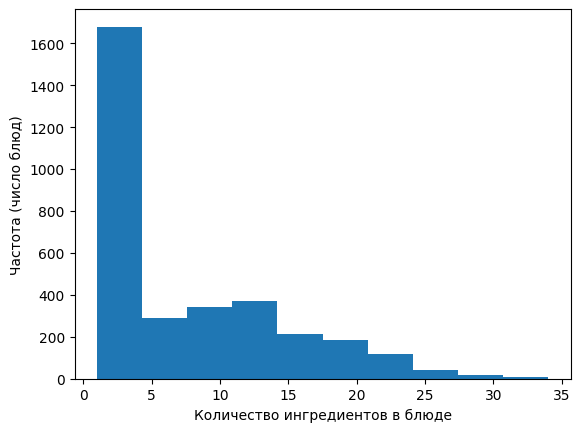

In [4]:
plt.hist(dish_df["ingredients"].str.split(';').apply(len))
plt.xlabel("Количество ингредиентов в блюде")
plt.ylabel("Частота (число блюд)")
plt.show()

Большая часть маленткие блюда, хотя есть до 35 одновременно используемых из 500+

Посмотрим на распределение общей массы блюда

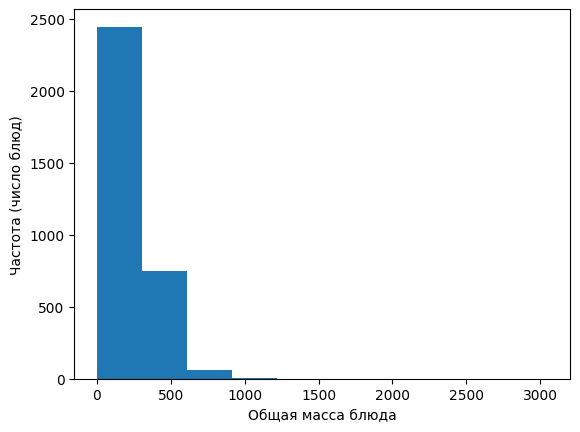

In [5]:
plt.hist(dish_df["total_mass"])
plt.xlabel("Общая масса блюда")
plt.ylabel("Частота (число блюд)")
plt.show()

Большая часть маленьких (до 500 уе), но есть и единичные большие. 3 кг?

Рассмотрим распределение калорийности

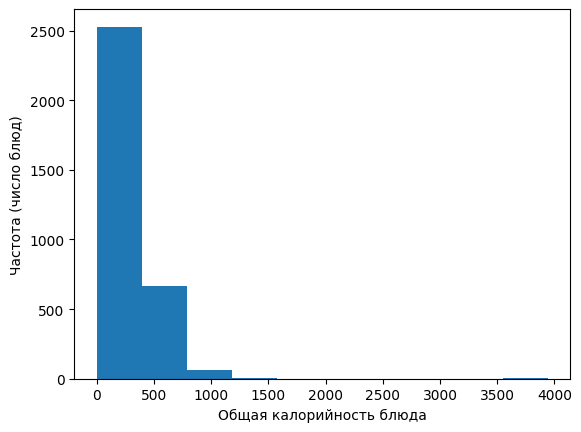

In [6]:
plt.hist(dish_df["total_calories"])
plt.xlabel("Общая калорийность блюда")
plt.ylabel("Частота (число блюд)")
plt.show()

Картина идентичная распределению для массы. Ожидаемо

In [7]:
print("Корреляция:", dish_df["total_calories"].corr(dish_df["total_mass"]))

Корреляция: 0.75967563138409


Корреляция ожидаемо высокая

## Бейзлайн без изображений

Раз наш состав блюд - это просто перечень ингредиентов, а масса сильно коррелирует с итоговой калорийностью, можно попробовать решить задачу без изображений на основе только состава и массы. Это будет стартовая метрика, от которой омжно отталкиваться далее в проекте

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np


dish_df_train = dish_df[dish_df["split"]=='train']
dish_df_test = dish_df[dish_df["split"]=='test']


vectorizer = CountVectorizer(token_pattern=r"ingr_\d+")
X_ingr_train = vectorizer.fit_transform(dish_df_train["ingredients"])
X_train = np.hstack([X_ingr_train.toarray(), dish_df_train[["total_mass"]].values])
y_train = dish_df_train["total_calories"].values

X_ingr_test = vectorizer.transform(dish_df_test["ingredients"])
X_test = np.hstack([X_ingr_test.toarray(), dish_df_test[["total_mass"]].values])
y_test = dish_df_test["total_calories"].values

Линейная модель

In [9]:
# модель
model = LinearRegression()
model.fit(X_train, y_train)

# предсказание
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))

MAE: 56.45429838053384


Близко к требуемому качеству "Модель будет считаться готовой к интеграции в продукт при точности оценки MAE < 50 (MAE — Mean Absolute Error) на тестовой выборке.". Попробуем взять нелинейную модель

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [300, 500, 800],
    "max_depth": [5, 10, 15],
    "l2_regularization": [0.0, 0.1, 1.0]
}

model = HistGradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=2,
    n_jobs=9,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая MAE:", -grid_search.best_score_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
Лучшие параметры: {'l2_regularization': 1.0, 'learning_rate': 0.05, 'max_depth': 15, 'max_iter': 800}
Лучшая MAE: 52.55862591439103


Близко, но не удовлетворяет требованиям. Бейзлайн значением будем считать 52.5 абсолютной ошибки

## Анализ изобрежений

"За кулисами" был написан класс датасета. Используем его для анализа изображений вместе с остальными данными

In [11]:
from dataset import CaloriesDataset, decode_features


dataset = CaloriesDataset(
    dish_df=dish_df,
    dish_images_path=IMAGES_PATH,
    ingredients_df=ingredients_df,
)

img_rgb, features, total_calories = dataset[0]
print(img_rgb, features, total_calories)


c:\Users\pasha\practicum_yandex_food_calorie_predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[[122 119 114]
  [124 121 116]
  [122 122 116]
  ...
  [134 127 121]
  [140 130 130]
  [144 134 134]]

 [[122 119 114]
  [124 121 116]
  [122 122 116]
  ...
  [134 127 121]
  [140 130 128]
  [143 133 131]]

 [[122 120 112]
  [124 122 114]
  [124 121 116]
  ...
  [134 127 121]
  [140 130 128]
  [143 133 131]]

 ...

 [[116 112 105]
  [113 109 102]
  [112 110 102]
  ...
  [133 127 129]
  [138 129 132]
  [142 133 136]]

 [[110 103  95]
  [115 108 100]
  [113 109 102]
  ...
  [135 126 129]
  [140 129 133]
  [143 132 136]]

 [[109 102  94]
  [115 108 100]
  [115 108 102]
  ...
  [136 125 129]
  [140 129 133]
  [143 132 136]]] [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1.   0.   0.
   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.

Низкокалорийные (≤5-й перцентиль)


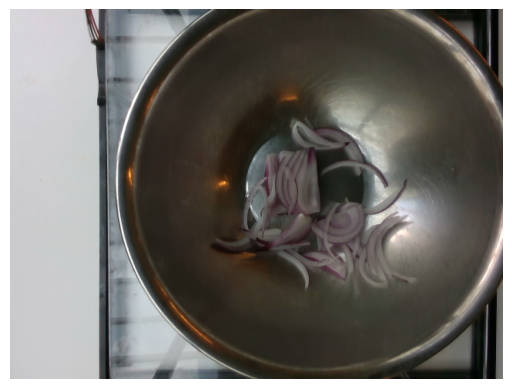

Масса: 43.0 г | Калории: 17.2
Состав: лук репчатый
--------------------------------------------------------------------------------


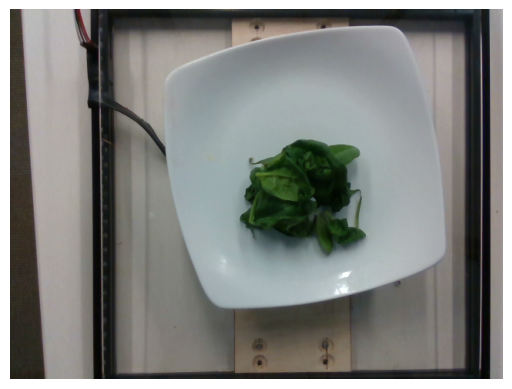

Масса: 10.0 г | Калории: 2.3
Состав: шпинат (сырой)
--------------------------------------------------------------------------------


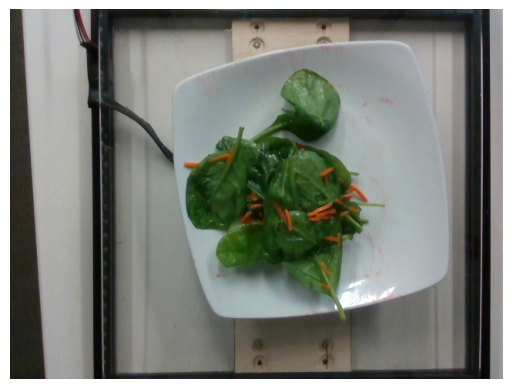

Масса: 40.0 г | Калории: 9.2
Состав: шпинат (сырой)
--------------------------------------------------------------------------------


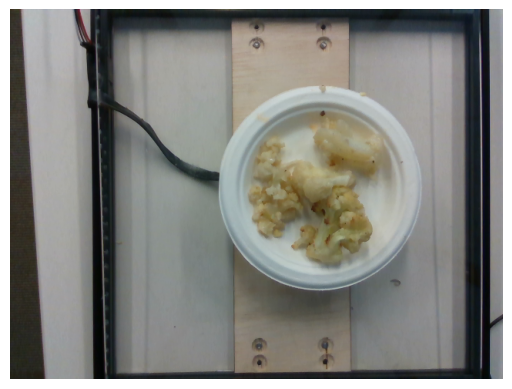

Масса: 64.0 г | Калории: 16.0
Состав: цветная капуста
--------------------------------------------------------------------------------


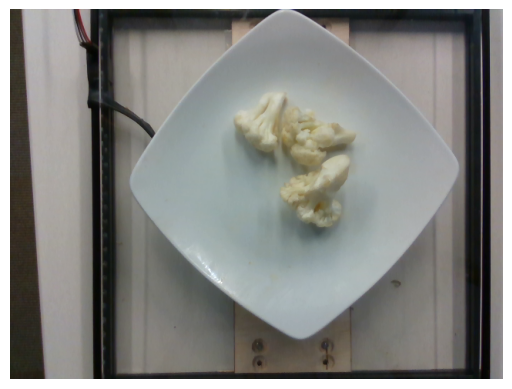

Масса: 59.0 г | Калории: 14.8
Состав: цветная капуста
--------------------------------------------------------------------------------
Средние (45–55 перцентиль)


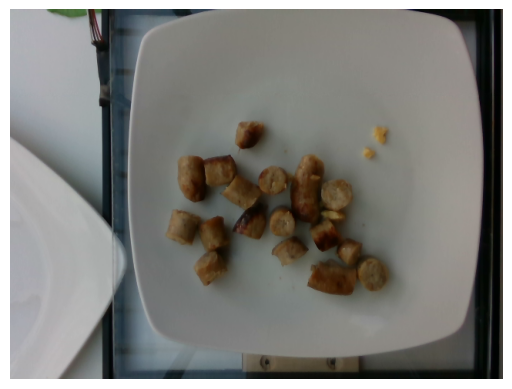

Масса: 122.0 г | Калории: 195.2
Состав: курино-яблочная колбаса
--------------------------------------------------------------------------------


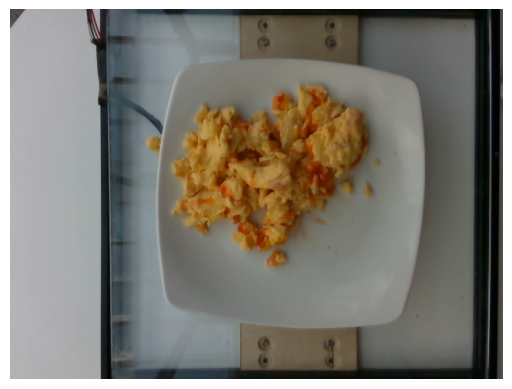

Масса: 134.0 г | Калории: 198.3
Состав: омлет
--------------------------------------------------------------------------------


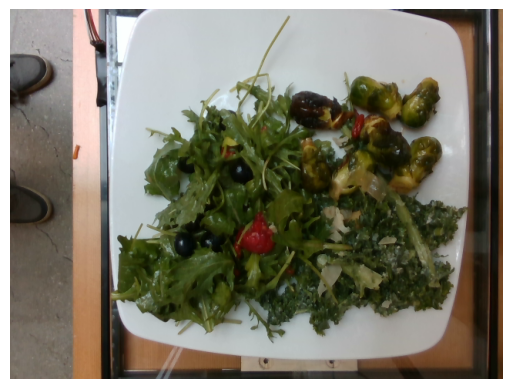

Масса: 227.0 г | Калории: 226.0
Состав: брюссельская капуста, яблоко, капуста кале, чеснок, лук-шалот, соус цезарь, сыр пармезан, булгур, оливковое масло, соль, гренки, перец, клюква, руккола, лимонный сок, петрушка, зелень горчицы
--------------------------------------------------------------------------------


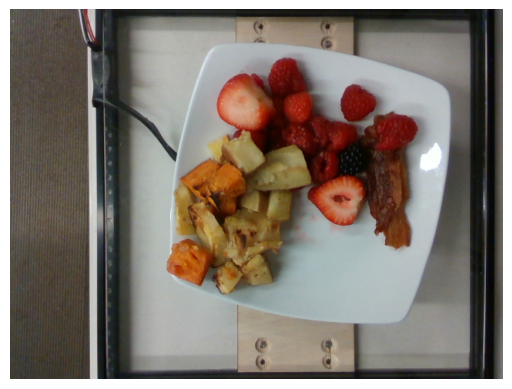

Масса: 233.0 г | Калории: 222.8
Состав: бекон, ягоды, батат, сладкий картофель
--------------------------------------------------------------------------------


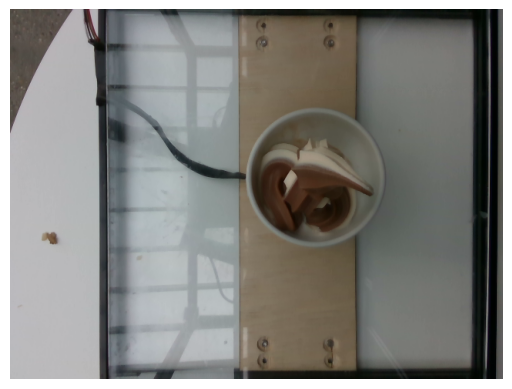

Масса: 110.0 г | Калории: 179.6
Состав: замороженный йогурт
--------------------------------------------------------------------------------
Высококалорийные (≥95-й перцентиль)


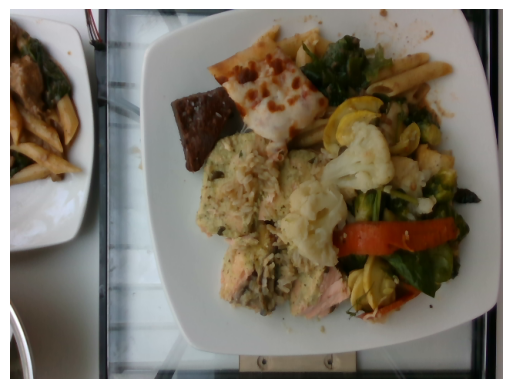

Масса: 750.0 г | Калории: 1116.4
Состав: сырная пицца, кабачки, коричневый рис, говядина, брокколи, шпинат (сырой), грибы, макароны, вино, лук репчатый, чеснок, лук-шалот, оливковое масло, чили, брауни, соль, лосось, сливки, лайм, сметана, перец халапеньо, цуккини, тимьян, лимонный сок, кинза, имбирь
--------------------------------------------------------------------------------


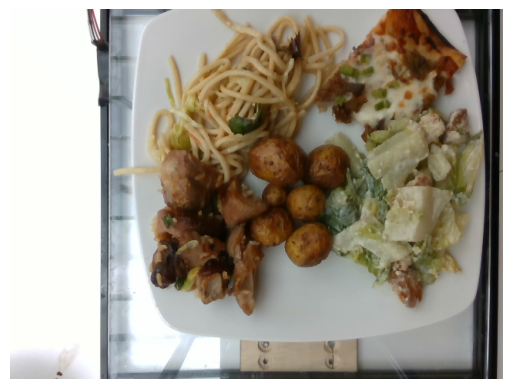

Масса: 479.0 г | Калории: 663.8
Состав: салат "цезарь", белый рис, зелень, морковь, редис, чеснок, капуста, оливковое масло, рисовая лапша, уксус, соль, перец, сахар, пицца, жареный картофель, свинина, соевый соус, бок чой, зеленый лук
--------------------------------------------------------------------------------


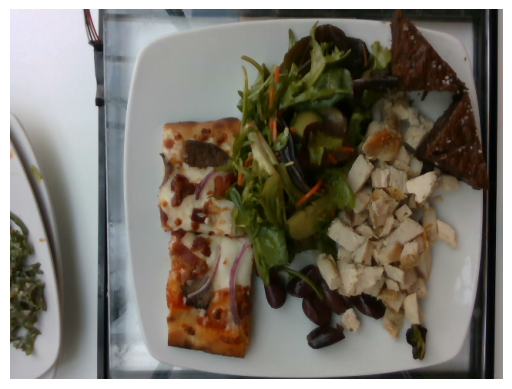

Масса: 435.0 г | Калории: 1030.2
Состав: сырная пицца, оливки, зелень, листья салата, огурцы, лук репчатый, оливковое масло, уксус, куриная грудка, брауни, соль, перец, лайм, помидоры черри
--------------------------------------------------------------------------------


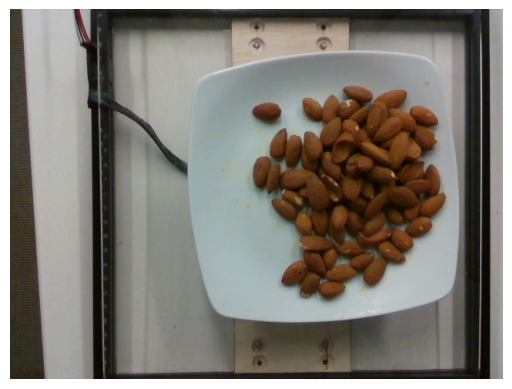

Масса: 128.0 г | Калории: 740.0
Состав: миндаль
--------------------------------------------------------------------------------


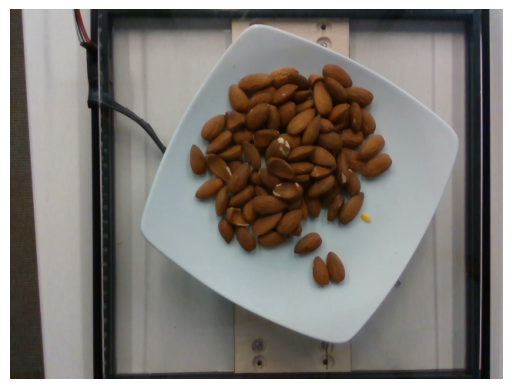

Масса: 133.0 г | Калории: 768.9
Состав: миндаль
--------------------------------------------------------------------------------


In [ ]:
import numpy as np

ingredients_df_ru = pd.read_csv(r"dataset\data\ingredients_ru.csv") # русский словарь названий ингредиентов для упрощения анализа

p5 = np.percentile(dish_df["total_calories"], 5)
p45 = np.percentile(dish_df["total_calories"], 45)
p55 = np.percentile(dish_df["total_calories"], 55)
p95 = np.percentile(dish_df["total_calories"], 95)

low_indices = dish_df.index[dish_df["total_calories"] <= p5].tolist()
mid_indices = dish_df.index[(dish_df["total_calories"] >= p45) & (dish_df["total_calories"] <= p55)].tolist()
high_indices = dish_df.index[dish_df["total_calories"] >= p95].tolist()

groups = {
    "Низкокалорийные (≤5-й перцентиль)": low_indices,
    "Средние (45–55 перцентиль)": mid_indices,
    "Высококалорийные (≥95-й перцентиль)": high_indices,
}

for group_name, indices in groups.items():
    print("=" * 100)
    print(group_name)
    print("=" * 100)

    for idx in indices[:5]: 
        img_rgb, features, total_calories = dataset[idx]
        ingr_names, mass = decode_features(features, ingredients_df_ru)

        if hasattr(img_rgb, "permute"):  
            img_show = img_rgb.permute(1, 2, 0).numpy()
        else:
            img_show = img_rgb

        plt.imshow(img_show)
        plt.axis("off")
        plt.show()

        print(f"Масса: {mass:.1f} г | Калории: {total_calories:.1f}")
        print("Состав:", ingr_names)
        print("-" * 80)


### Выводы по EDA

Общее:
- Датасет содержит изображения блюд, мультиметки ингредиентов (~555 категорий), массу и целевую переменную — калорийность.  
- Встречаются 4 значения `"deprecated"`, которые являются заглушками.  
- По количеству ингредиентов: большинство блюд состоят из малого числа компонентов (до 5), но встречаются случаи до 35+.  
- Масса блюд в основном до 500 г, но есть выбросы (единичные до 3 кг).  
- Распределение калорийности схоже с распределением массы — больше масса, выше калорийность.  
- Корреляция между массой и калорийностью высокая (~0.76), что ожидаемо.  
- Построен бейзлайн **без изображений**: модель учитывает только табличные признаки (массу и ингредиенты). Этот результат (52.5 MAE) будет точкой отсчета для сравнения с мультимодальной моделями.

Аугментации:
- Задача формулируется как предсказание калорийности блюда по **изображению + дополнительным признакам** (масса, категориальные признаки состава).  
- Для решения потребуется **мультимодальная модель**, объединяющая визуальные и табличные данные. Использование данных как "текст" избыточно и шумно.  
- После анализа выше можно выделить следующий пул аугментаций:
  - повороты (10–15 градусов),
  - горизонтальные и вертикальные флипы,
  - случайный кроп/масштабирование (небольшое, чтобы блюдо было в кадре),
  - легкое размытие,
  - сжатие изображения.  

- Основная метрика качества — **MAE**, дополнительная — **R2**, чтобы оценивать, насколько хорошо модель описывает зависимость. 
- На текущем этапе:
  - данные собраны и связаны с метками массы и категорий,
  - подготовлен пайплайн для обучения,
  - определены подходы к аугментации и метрики для оценки.
